In [19]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")


Device in use: cuda


In [20]:
# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(original, reconstructed, data_range=original.max() - original.min())
    return mse_value, psnr_value


Original image shape: (1024, 1024, 3) Type: uint8


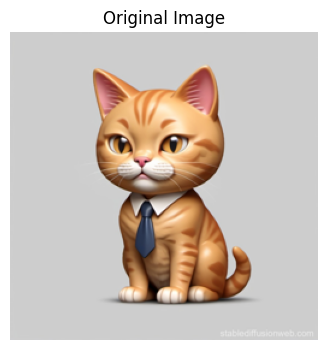

In [21]:
# Load image
# image_url = "https://www.bu.edu/home/img/masterplate112x50-retina.png"
image_url='1.jpg'
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

image_pil = Image.fromarray(image_original)


image_original = np.array(image_pil.resize((256, 256)))

# Display the original image
plt.figure(figsize=(6, 4))
plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()


In [22]:
# Convert  to [0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape


image_tensor = torch.tensor(image, dtype=torch.float32, device=device)


In [228]:
import torch.nn as nn
import itertools

# Define the model class
class NeuralField(nn.Module):
    def __init__(self, hidden_layers=4, hidden_width=128, fourier_features=False):
        super(NeuralField, self).__init__()
        self.fourier_features = fourier_features
        if self.fourier_features:
            self.fourier_dim = 256
            self.fourier_scale = 10.0
            self.B = nn.Parameter(torch.randn(2, self.fourier_dim) * self.fourier_scale, requires_grad=False).to(device)
            input_dim = self.fourier_dim * 2
        else:
            input_dim = 2

        layers = []
        layers.append(nn.Linear(input_dim, hidden_width))
        for _ in range(hidden_layers):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_width, hidden_width))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_width, 3))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        if self.fourier_features:
            x = (2 * np.pi * x) @ self.B
            x = torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
        return self.model(x)


In [23]:
# Prepare data
H, W, C = image_tensor.shape
y = torch.linspace(-1, 1, H, device=device)
x = torch.linspace(-1, 1, W, device=device)
grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
coords = torch.stack([grid_x.reshape(-1), grid_y.reshape(-1)], dim=-1)
pixels = image_tensor.reshape(-1, 3)


In [230]:
# Define the model
model = NeuralField(fourier_features=True).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [231]:
# Initialize and train models
model_fourier = NeuralField(fourier_features=True).to(device)
optimizer_fourier = torch.optim.Adam(model_fourier.parameters(), lr=1e-4)

model_no_fourier = NeuralField(fourier_features=False).to(device)
optimizer_no_fourier = torch.optim.Adam(model_no_fourier.parameters(), lr=1e-4)

criterion = nn.MSELoss()


In [232]:
epochs = 20000
fourier_losses = []

# Train model with Fourier features
start_time = time.time()
for epoch in range(epochs):
    optimizer_fourier.zero_grad()
    outputs = model_fourier(coords)
    loss = criterion(outputs, pixels)
    loss.backward()
    optimizer_fourier.step()
    fourier_losses.append(loss.item())  # 记录损失
    if (epoch + 1) % 500 == 0:
        print(f"[Fourier] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
training_time_fourier = time.time() - start_time
print(f"Training time with Fourier features: {training_time_fourier:.2f} seconds")

[Fourier] Epoch [500/20000], Loss: 0.002235
[Fourier] Epoch [1000/20000], Loss: 0.000573
[Fourier] Epoch [1500/20000], Loss: 0.000257
[Fourier] Epoch [2000/20000], Loss: 0.000151
[Fourier] Epoch [2500/20000], Loss: 0.000088
[Fourier] Epoch [3000/20000], Loss: 0.000058
[Fourier] Epoch [3500/20000], Loss: 0.000042
[Fourier] Epoch [4000/20000], Loss: 0.000033
[Fourier] Epoch [4500/20000], Loss: 0.000028
[Fourier] Epoch [5000/20000], Loss: 0.000024
[Fourier] Epoch [5500/20000], Loss: 0.000021
[Fourier] Epoch [6000/20000], Loss: 0.000019
[Fourier] Epoch [6500/20000], Loss: 0.000017
[Fourier] Epoch [7000/20000], Loss: 0.000018
[Fourier] Epoch [7500/20000], Loss: 0.000015
[Fourier] Epoch [8000/20000], Loss: 0.000014
[Fourier] Epoch [8500/20000], Loss: 0.000013
[Fourier] Epoch [9000/20000], Loss: 0.000013
[Fourier] Epoch [9500/20000], Loss: 0.000011
[Fourier] Epoch [10000/20000], Loss: 0.000020
[Fourier] Epoch [10500/20000], Loss: 0.000012
[Fourier] Epoch [11000/20000], Loss: 0.000010
[Fourier

In [255]:
# Train model without Fourier features
epochs = 20000
no_fourier_losses = []
start_time = time.time()
for epoch in range(epochs):
    optimizer_no_fourier.zero_grad()
    outputs = model_no_fourier(coords)
    loss = criterion(outputs, pixels)
    loss.backward()
    optimizer_no_fourier.step()
    no_fourier_losses.append(loss.item())  # 记录损失
    if (epoch + 1) % 500 == 0:
        print(f"[No Fourier] Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
training_time_no_fourier = time.time() - start_time
print(f"Training time without Fourier features: {training_time_no_fourier:.2f} seconds")

[No Fourier] Epoch [500/20000], Loss: 0.002097
[No Fourier] Epoch [1000/20000], Loss: 0.002094
[No Fourier] Epoch [1500/20000], Loss: 0.002099
[No Fourier] Epoch [2000/20000], Loss: 0.002095
[No Fourier] Epoch [2500/20000], Loss: 0.002088
[No Fourier] Epoch [3000/20000], Loss: 0.002077
[No Fourier] Epoch [3500/20000], Loss: 0.002077
[No Fourier] Epoch [4000/20000], Loss: 0.002069
[No Fourier] Epoch [4500/20000], Loss: 0.002063
[No Fourier] Epoch [5000/20000], Loss: 0.002063
[No Fourier] Epoch [5500/20000], Loss: 0.002057
[No Fourier] Epoch [6000/20000], Loss: 0.002052
[No Fourier] Epoch [6500/20000], Loss: 0.002051
[No Fourier] Epoch [7000/20000], Loss: 0.002044
[No Fourier] Epoch [7500/20000], Loss: 0.002042
[No Fourier] Epoch [8000/20000], Loss: 0.002047
[No Fourier] Epoch [8500/20000], Loss: 0.002032
[No Fourier] Epoch [9000/20000], Loss: 0.002030
[No Fourier] Epoch [9500/20000], Loss: 0.002030
[No Fourier] Epoch [10000/20000], Loss: 0.002030
[No Fourier] Epoch [10500/20000], Loss: 

In [234]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_fourier = count_parameters(model_fourier)
params_no_fourier = count_parameters(model_no_fourier)

print(f"Number of parameters (with Fourier features): {params_fourier}")
print(f"Number of parameters (without Fourier features): {params_no_fourier}")


Number of parameters (with Fourier features): 132099
Number of parameters (without Fourier features): 66819


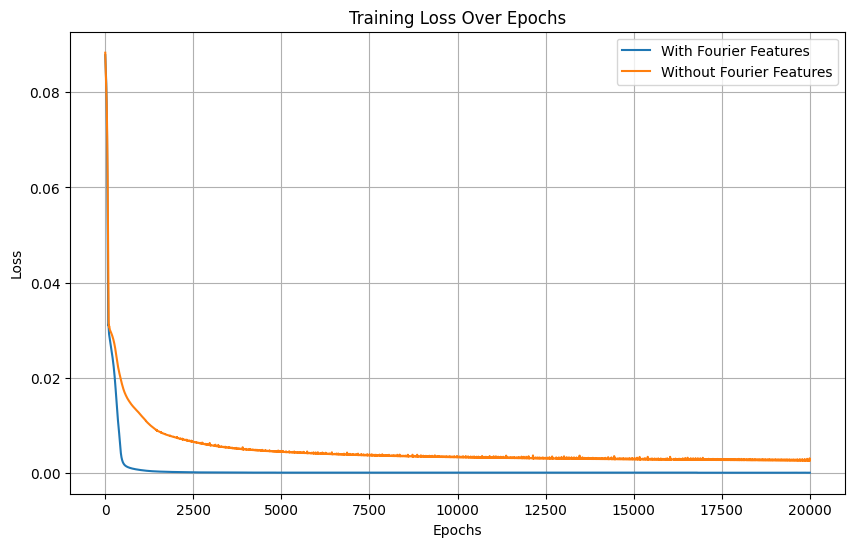

In [235]:
# 绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), fourier_losses, label='With Fourier Features')
plt.plot(range(1, epochs + 1), no_fourier_losses, label='Without Fourier Features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [256]:
# Reconstruct images
with torch.no_grad():
    reconstructed_fourier = model_fourier(coords).reshape(H, W, 3).cpu().numpy()
    reconstructed_no_fourier = model_no_fourier(coords).reshape(H, W, 3).cpu().numpy()

# evaluation metrics
mse_fourier, psnr_fourier = calculate_metrics(image, reconstructed_fourier)
mse_no_fourier, psnr_no_fourier = calculate_metrics(image, reconstructed_no_fourier)

print(f"Model with Fourier features - MSE: {mse_fourier:.6f}, PSNR: {psnr_fourier:.2f}dB")
print(f"Model without Fourier features - MSE: {mse_no_fourier:.6f}, PSNR: {psnr_no_fourier:.2f}dB")


Model with Fourier features - MSE: 0.000007, PSNR: 51.83dB
Model without Fourier features - MSE: 0.001957, PSNR: 27.08dB


In [237]:
# # Define functions
# def generate_random_directions(num_directions):
#     directions = []
#     for _ in range(num_directions):
#         dx, dy = torch.randn(2, device=device)
#         magnitude = torch.sqrt(dx**2 + dy**2)
#         dx /= magnitude
#         dy /= magnitude
#         directions.append((dx, dy))
#     return directions

# def calculate_coordinates(Px, Py, dx, dy):
#     return dx * Px + dy * Py

# def build_1d_curve(Px, Py, values, dx, dy):
#     coordinates = calculate_coordinates(Px, Py, dx, dy)
#     sorted_coords, sorted_indices = torch.sort(coordinates)
#     sorted_values = values[sorted_indices]

#     # Process each channel separately
#     curves = []
#     for c in range(3):
#         channel_values = sorted_values[:, c]
#         unique_coords, inverse_indices, counts = torch.unique(
#             sorted_coords, return_inverse=True, return_counts=True
#         )
#         sum_values = torch.zeros_like(unique_coords)
#         sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
#         mean_values = sum_values / counts.float()
#         curves.append(torch.stack((unique_coords, mean_values), dim=1))
#     return curves  # Returns curves for each channel

# def predict_image(curves, dx, dy, width, height):
#     Py, Px = torch.meshgrid(
#         torch.arange(height, device=device),
#         torch.arange(width, device=device),
#         indexing='ij'
#     )
#     Px = Px.flatten()
#     Py = Py.flatten()
#     coordinates = calculate_coordinates(Px, Py, dx, dy)
#     predicted_values = []
#     for c in range(3):
#         curve = curves[c]
#         interp_func = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
#         predicted_values.append(interp_func)
#     predicted_values = torch.stack(predicted_values, dim=1)
#     predicted_values = torch.clamp(predicted_values, 0, 255)
#     predicted_image = predicted_values.reshape((height, width, 3))
#     return predicted_image

# def downsample_pixels(Px, Py, sample_size=5000):
#     total_pixels = len(Px)
#     if total_pixels <= sample_size:
#         return Px, Py
#     else:
#         sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
#         return Px[sampled_indices], Py[sampled_indices]

# def select_initial_sampling_points(num_points, width, height):
#     x0 = torch.randint(0, width, (num_points,), device=device)
#     y0 = torch.randint(0, height, (num_points,), device=device)
#     return x0, y0

# def torch_interp_lerp(x, xp, fp):
#     indices = torch.searchsorted(xp, x)
#     indices = torch.clamp(indices, 1, len(xp) - 1)

#     x0 = xp[indices - 1]
#     x1 = xp[indices]
#     y0 = fp[indices - 1]
#     y1 = fp[indices]

#     weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
#     return torch.lerp(y0, y1, weight)


In [238]:
# # Parameter
# num_directions = 4
# num_iterations = 4960
# print(f"Processing: Number of directions={num_directions}, Iterations={num_iterations}")

# # Initialization
# height, width, channels = image_tensor.shape
# directions = generate_random_directions(num_directions)
# initial_sample_size = 1
# sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
# sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

# Py, Px = torch.meshgrid(
#     torch.arange(height, device=device),
#     torch.arange(width, device=device),
#     indexing='ij'
# )
# Px = Px.flatten()
# Py = Py.flatten()


In [239]:
# # Iterative process
# start_time = time.time()
# for t in tqdm(range(num_iterations), desc="Iterations"):
#     downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
#     av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
#     combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

#     for idx in range(num_directions):
#         dx, dy = directions[idx]
#         curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
#         pv_channels = []
#         for c in range(channels):
#             curve = curves[c]
#             pv = torch_interp_lerp(
#                 calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
#                 curve[:, 0], curve[:, 1]
#             )
#             pv_channels.append(pv)
#         pv = torch.stack(pv_channels, dim=1)
#         combined_predicted_values += pv

#     combined_predicted_values /= num_directions
#     downsampled_error = torch.mean(torch.abs(av - combined_predicted_values), dim=1)
#     top_k_indices = torch.argsort(downsampled_error)[-10:]
#     error_y = downsampled_Py[top_k_indices]
#     error_x = downsampled_Px[top_k_indices]

#     sampled_Px = torch.cat([sampled_Px, error_x])
#     sampled_Py = torch.cat([sampled_Py, error_y])
#     sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

# processing_time = time.time() - start_time
# print(f"Total time for random direction projection method: {processing_time:.2f} seconds")


In [240]:
# # Reconstruct images from predictions
# predicted_images = []
# for idx in range(num_directions):
#     dx, dy = directions[idx]
#     curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
#     predicted_image = predict_image(curves, dx, dy, width, height)
#     predicted_images.append(predicted_image)


In [241]:
# # average predicted image
# final_predicted_image_avg = torch.stack(predicted_images).mean(dim=0)
# final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
# reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

# # evaluation metrics
# mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)
# print(f"Method 2 (Average) - MSE: {mse2_avg:.6f}, PSNR: {psnr2_avg:.2f}dB")


In [242]:
# # Weighted 
# predicted_images_tensor = torch.stack(predicted_images)
# predicted_images_tensor = predicted_images_tensor.permute(1, 2, 3, 0)
# predicted_images_tensor = predicted_images_tensor.reshape(-1, num_directions)
# original_image_vector = (image_tensor * 255.0).view(-1)

# #  least squares 
# solution = torch.linalg.lstsq(predicted_images_tensor, original_image_vector.unsqueeze(1))
# w_opt = solution.solution.squeeze()

# # final predicted image
# final_predicted_image_vector = predicted_images_tensor @ w_opt
# final_predicted_image_opt = final_predicted_image_vector.view(height, width, channels)
# final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
# reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

# # optimized evaluation metrics
# mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)
# print(f"Method 2 (Optimized) - MSE: {mse2_opt:.6f}, PSNR: {psnr2_opt:.2f}dB")


Sampling Iterations: 100%|██████████| 1336/1336 [04:25<00:00,  5.03it/s]


Sampling phase completed in 265.36 seconds
Total sample points collected: 13361
Reconstruction phase completed in 0.21 seconds
Average Predicted Image - MSE: 0.008909, PSNR: 20.50dB
Optimized Predicted Image - MSE: 0.001149, PSNR: 29.40dB


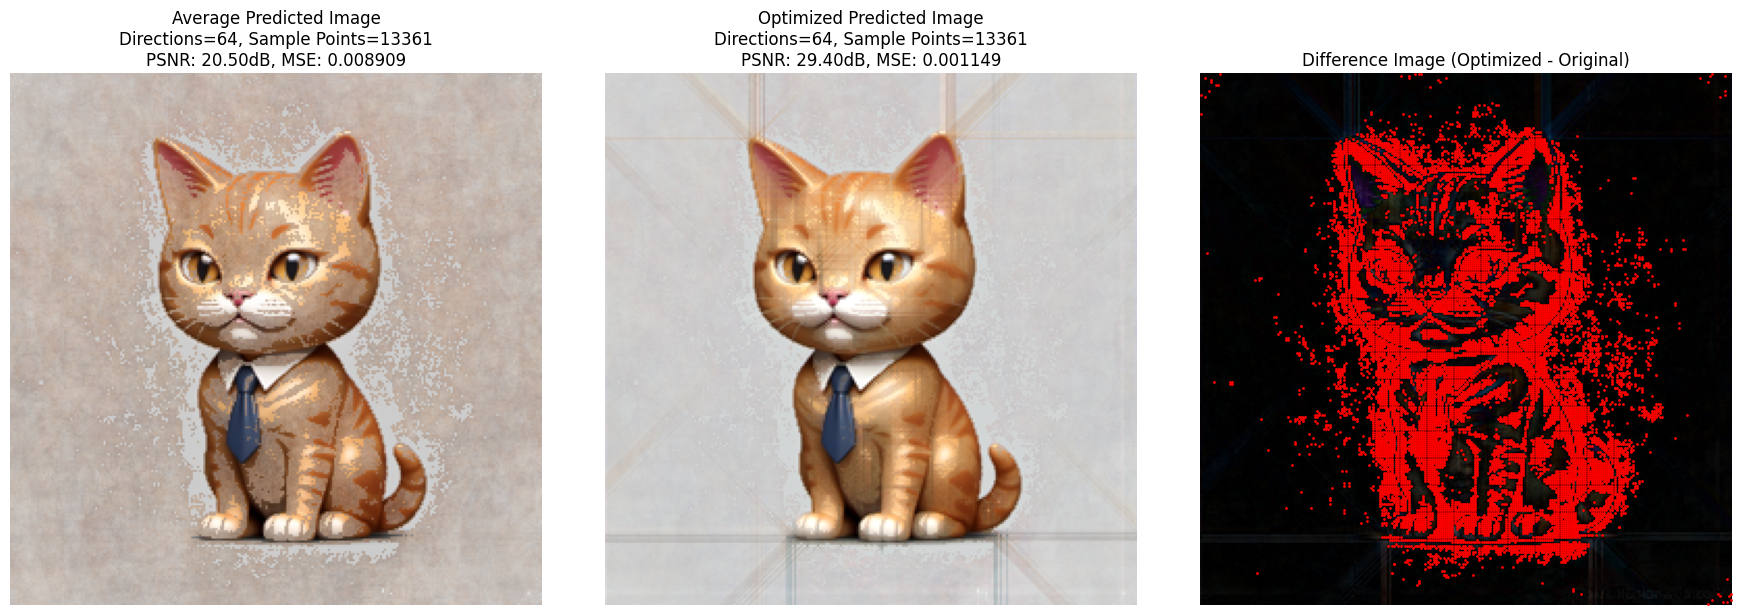

In [243]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

torch.manual_seed(1)

# Define functions
def generate_random_directions(num_directions):
    # Generate the first random angle
    print()
    theta0 = torch.rand(1, device=device) * 2 * np.pi  # Random angle in [0, 2π)

    # Compute angle increment
    delta_theta = 2 * np.pi / num_directions

    # Generate the angles starting from theta0
    if num_directions > 1:
        angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
    else:
        angles = theta0

    # Wrap angles back into [0, 2π)
    angles = angles % (2 * np.pi)

    # Compute directions
    directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
    directions = [(dx.item(), dy.item()) for dx, dy in directions]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Parameters for Analysis
num_directions_sampling = 64  # More directions during sampling
num_iterations_sampling = 1336 # Number of iterations for sampling

# num_directions_reconstruction = 4  # Fewer directions during reconstruction

# Sampling Phase
# Generate random directions for sampling
directions_sampling = generate_random_directions(num_directions_sampling)

# Initialize sample points
initial_sample_size = 1
sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

Py, Px = torch.meshgrid(
    torch.arange(height, device=device),
    torch.arange(width, device=device),
    indexing='ij'
)
Px = Px.flatten()
Py = Py.flatten()

# Sampling process
start_time_sampling = time.time()
for t in tqdm(range(num_iterations_sampling), desc="Sampling Iterations"):
    downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
    av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
    combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

    for idx in range(num_directions_sampling):
        dx, dy = directions_sampling[idx]
        curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
        pv_channels = []
        for c in range(channels):
            curve = curves[c]
            pv = torch_interp_lerp(
                calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                curve[:, 0], curve[:, 1]
            )
            pv_channels.append(pv)
        pv = torch.stack(pv_channels, dim=1)
        combined_predicted_values += pv

    combined_predicted_values /= num_directions_sampling
    downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

    top_k_indices = torch.argsort(downsampled_error)[-10:]
    error_y = downsampled_Py[top_k_indices]
    error_x = downsampled_Px[top_k_indices]

    sampled_Px = torch.cat([sampled_Px, error_x])
    sampled_Py = torch.cat([sampled_Py, error_y])
    sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

sampling_time = time.time() - start_time_sampling
print(f"Sampling phase completed in {sampling_time:.2f} seconds")
print(f"Total sample points collected: {len(sampled_Px)}")

# Reconstruction Phase
# Generate random directions for reconstruction
# directions_reconstruction = generate_random_directions(num_directions_reconstruction)

# Reconstruct images using the selected sample points and fewer directions
start_time_reconstruction = time.time()
final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_sampling):
    dx, dy = directions_sampling[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    final_predicted_image_sum += predicted_image

final_predicted_image_avg = final_predicted_image_sum / num_directions_sampling
final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
reconstructed_avg = final_predicted_image_avg.cpu().numpy() / 255.0

# Evaluation metrics
mse_avg, psnr_avg = calculate_metrics(image, reconstructed_avg)

reconstruction_time = time.time() - start_time_reconstruction
print(f"Reconstruction phase completed in {reconstruction_time:.2f} seconds")
print(f"Average Predicted Image - MSE: {mse_avg:.6f}, PSNR: {psnr_avg:.2f}dB")

# Optimized Reconstruction using Least Squares
# Sample a subset of pixels for the least squares problem
num_samples_ls = 10000
sample_indices_ls = torch.randint(0, height * width, (num_samples_ls,), device=device)
sampled_Px_ls = (sample_indices_ls % width).long()
sampled_Py_ls = (sample_indices_ls // width).long()
original_values_ls = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

# Initialize X matrix for least squares
X_ls = torch.zeros((num_samples_ls, num_directions_sampling, channels), device=device)
for idx in range(num_directions_sampling):
    dx, dy = directions_sampling[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    for c in range(channels):
        curve = curves[c]
        predicted_values = torch_interp_lerp(
            calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
            curve[:, 0], curve[:, 1]
        )
        X_ls[:, idx, c] = predicted_values

# Solve least squares problem for each channel
w_opt = torch.zeros((num_directions_sampling, channels), device=device)
for c in range(channels):
    X_channel = X_ls[:, :, c]
    y_channel = original_values_ls[:, c]
    solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
    w_opt_channel = solution.solution.squeeze()
    w_opt[:, c] = w_opt_channel

# Reconstruct the final predicted image using optimized weights
final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
for idx in range(num_directions_sampling):
    dx, dy = directions_sampling[idx]
    curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
    predicted_image = predict_image(curves, dx, dy, width, height)
    for c in range(channels):
        final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
reconstructed_opt = final_predicted_image_opt.cpu().numpy() / 255.0

# Optimized evaluation metrics
mse_opt, psnr_opt = calculate_metrics(image, reconstructed_opt)
print(f"Optimized Predicted Image - MSE: {mse_opt:.6f}, PSNR: {psnr_opt:.2f}dB")

# Difference Image (Optimized - Original)
difference_image = np.abs(reconstructed_opt - image)

# Plotting Results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(reconstructed_avg)
axes[0].set_title(
    f'Average Predicted Image\nDirections={num_directions_sampling}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_avg:.2f}dB, MSE: {mse_avg:.6f}'
)
axes[0].axis('off')

axes[1].imshow(reconstructed_opt)
axes[1].set_title(
    f'Optimized Predicted Image\nDirections={num_directions_sampling}, '
    f'Sample Points={len(sampled_Px)}\nPSNR: {psnr_opt:.2f}dB, MSE: {mse_opt:.6f}'
)
axes[1].axis('off')

axes[2].imshow(difference_image)
axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label='Sample Points')
axes[2].set_title('Difference Image (Optimized - Original)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [244]:
# def generate_random_directions(num_directions):
#     # Generate the first random angle
#     theta0 = torch.rand(1, device=device) * 2 * np.pi  # Random angle in [0, 2π)

#     # Compute angle increment
#     delta_theta = 2 * np.pi / num_directions

#     # Generate the angles starting from theta0
#     if num_directions > 1:
#         angles = theta0 + delta_theta * torch.arange(0, num_directions, device=device)
#     else:
#         angles = theta0

#     # Wrap angles back into [0, 2π)
#     angles = angles % (2 * np.pi)

#     # Compute directions
#     directions = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)
#     directions = [(dx.item(), dy.item()) for dx, dy in directions]
#     return directions

# generate_random_directions(5)

Kernel Regression Batches: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]

Kernel Regression Prediction Time: 0.98 seconds
Kernel Regression - MSE: 0.050738, PSNR: 12.95dB


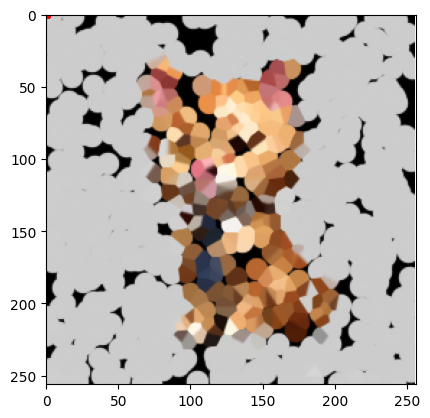

: 

In [ ]:

sample_size = 880
indices = torch.randperm(coords.shape[0])[:sample_size]
sample_coords = coords[indices]
sample_pixels = pixels[indices]
# sample_coords = coords[:]
# sample_pixels = pixels[indices]

def gaussian_kernel(x, y, sigma=0.05):
    return torch.exp(-torch.sum((x - y) ** 2, dim=2) / (2 * sigma ** 2))

def kernel_regression_predict(test_coords, train_coords, train_pixels, sigma=0.05, batch_size=10000):
    predictions = []
    num_batches = (test_coords.shape[0] + batch_size - 1) // batch_size
    for i in tqdm(range(num_batches), desc="Kernel Regression Batches"):
        start = i * batch_size
        end = min((i + 1) * batch_size, test_coords.shape[0])
        batch_coords = test_coords[start:end]
        
 
        K = gaussian_kernel(batch_coords.unsqueeze(1), train_coords.unsqueeze(0), sigma)  # shape: [batch_size, sample_size]
        

        K_sum = K.sum(dim=1, keepdim=True)
        K_normalized = K / (K_sum + 1e-8)

        batch_predictions = K_normalized @ train_pixels  
        predictions.append(batch_predictions)
    
    predictions = torch.cat(predictions, dim=0)
    return predictions


coords_cpu = coords.cpu()
sample_coords_cpu = sample_coords.cpu()
sample_pixels_cpu = sample_pixels.cpu()


sigma = 0.01 
start_time = time.time()
predicted_pixels = kernel_regression_predict(coords_cpu, sample_coords_cpu, sample_pixels_cpu, sigma=sigma)
kernel_regression_time = time.time() - start_time
print(f"Kernel Regression Prediction Time: {kernel_regression_time:.2f} seconds")


reconstructed_kernel = predicted_pixels.reshape(H, W, 3).numpy()

mse_kernel, psnr_kernel = calculate_metrics(image, reconstructed_kernel)
print(f"Kernel Regression - MSE: {mse_kernel:.6f}, PSNR: {psnr_kernel:.2f}dB")


plt.imshow(reconstructed_kernel)
plt.xlim([0, W])
plt.ylim([H, 0])  # if needed to invert the y-axis
plt.scatter(sample_coords[:,1].cpu().numpy(), sample_coords[:,0].cpu().numpy(), c='red', s=5)
plt.show()



In [28]:
coords

tensor([[-1.0000, -1.0000],
        [-0.9922, -1.0000],
        [-0.9843, -1.0000],
        ...,
        [ 0.9843,  1.0000],
        [ 0.9922,  1.0000],
        [ 1.0000,  1.0000]], device='cuda:0')

PSNR: 27.46 dB, MSE: 0.001795


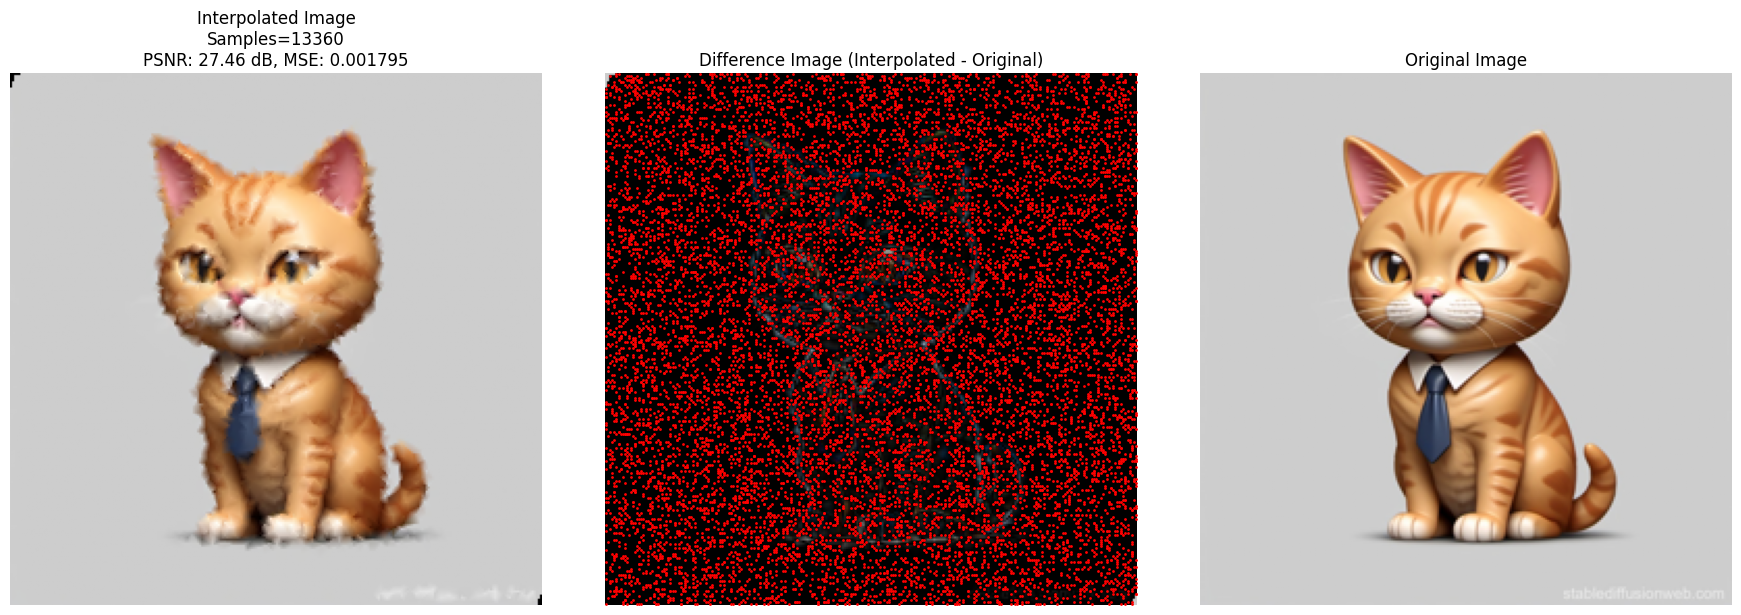

In [246]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from PIL import Image
from scipy.interpolate import LinearNDInterpolator


# Function to select random sampling points
def select_random_sampling_points(num_points, width, height):
    x = torch.randint(0, width, (num_points,), device=device)
    y = torch.randint(0, height, (num_points,), device=device)
    return x, y

# Function to calculate metrics
def calculate_metrics(original_image, reconstructed_image):
    mse = mean_squared_error(original_image, reconstructed_image)
    psnr = peak_signal_noise_ratio(original_image, reconstructed_image, data_range=1.0)
    return mse, psnr

# Parameters for Analysis
num_samples_list = [13360]  # Different sample counts to test
threshold = 16 * 960000  # Adjust as needed

# Lists to store MSE and PSNR values for plotting
mse_history = []
psnr_history = []
iteration_history = []

# Original image for plotting
image_original = image  # This is your original image as a NumPy array

# Loop over different numbers of samples
for num_samples in num_samples_list:
    # Ensure the total sample points do not exceed the threshold
    if num_samples > threshold:
        continue

    # Select sample points
    sampled_Px, sampled_Py = select_random_sampling_points(num_samples, width, height)
    sampled_Px_np = sampled_Px.cpu().numpy().astype(int)
    sampled_Py_np = sampled_Py.cpu().numpy().astype(int)
    sampled_coords = np.stack((sampled_Px_np, sampled_Py_np), axis=-1)  # (x, y) order

    # Extract sampled values for each channel
    sampled_values = (image_tensor * 255.0).cpu().numpy()[sampled_Py_np, sampled_Px_np]  # (y, x) indexing

    # Initialize interpolators for each channel
    interpolators = []
    for c in range(3):
        interpolator = LinearNDInterpolator(sampled_coords, sampled_values[:, c], fill_value=0)
        interpolators.append(interpolator)

    # Create grid for prediction
    grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))
    grid_points = np.stack((grid_x.flatten(), grid_y.flatten()), axis=-1)  # (x, y) order

    # Predict image using interpolators
    predicted_channels = []
    for c in range(3):
        predicted = interpolators[c](grid_points[:, 0], grid_points[:, 1])
        # Handle NaNs resulting from extrapolation
        predicted = np.nan_to_num(predicted, nan=0.0)
        predicted_channels.append(predicted)

    # Stack channels and reshape to image
    predicted_image = np.stack(predicted_channels, axis=-1).reshape((height, width, 3))
    predicted_image = np.clip(predicted_image, 0, 255)
    reconstructed = predicted_image / 255.0  # Normalize back to [0,1]

    # Evaluation metrics
    mse, psnr = calculate_metrics(image, reconstructed)
    mse_history.append(mse)
    psnr_history.append(psnr)
    iteration_history.append(num_samples)

    # Difference Image
    difference_image = np.abs(reconstructed - image)

    # Plotting Results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Interpolated Image
    axes[0].imshow(reconstructed)
    axes[0].set_title(f'Interpolated Image\nSamples={num_samples}\nPSNR: {psnr:.2f} dB, MSE: {mse:.6f}')
    axes[0].axis('off')
    print(f'PSNR: {psnr:.2f} dB, MSE: {mse:.6f}')

    # Difference Image with sample points
    axes[1].imshow(difference_image)
    axes[1].scatter(sampled_Px_np, sampled_Py_np, c='red', s=1, label='Sample Points')
    axes[1].set_title('Difference Image (Interpolated - Original)')
    axes[1].axis('off')

    # Original Image for reference
    axes[2].imshow(image_original)
    axes[2].set_title('Original Image')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Optional: Plotting MSE and PSNR over number of samples
# plt.figure(figsize=(12, 10))

# # Plot MSE (Interpolated)
# plt.subplot(2, 1, 1)
# plt.plot(iteration_history, mse_history, marker='o', label='MSE (Interpolated)')
# plt.xlabel('Number of Samples')
# plt.ylabel('MSE')
# plt.title('MSE over Number of Samples (Interpolated)')
# plt.legend()
# plt.grid(True)

# # Plot PSNR (Interpolated)
# plt.subplot(2, 1, 2)
# plt.plot(iteration_history, psnr_history, marker='s', color='orange', label='PSNR (Interpolated)')
# plt.xlabel('Number of Samples')
# plt.ylabel('PSNR (dB)')
# plt.title('PSNR over Number of Samples (Interpolated)')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


# Plotting MSE and PSNR
# plt.figure(figsize=(12, 10))

# Plot MSE (Interpolated)
# plt.subplot(2, 1, 1)
# plt.plot(iteration_history, mse_history, marker='o', label='MSE (Interpolated)')
# plt.xlabel('Number of Samples')
# plt.ylabel('MSE')
# plt.title('MSE over Number of Samples (Interpolated)')
# plt.legend()
# plt.grid(True)

# # Plot PSNR (Interpolated)
# plt.subplot(2, 1, 2)
# plt.plot(iteration_history, psnr_history, marker='s', color='orange', label='PSNR (Interpolated)')
# plt.xlabel('Number of Samples')
# plt.ylabel('PSNR (dB)')
# plt.title('PSNR over Number of Samples (Interpolated)')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


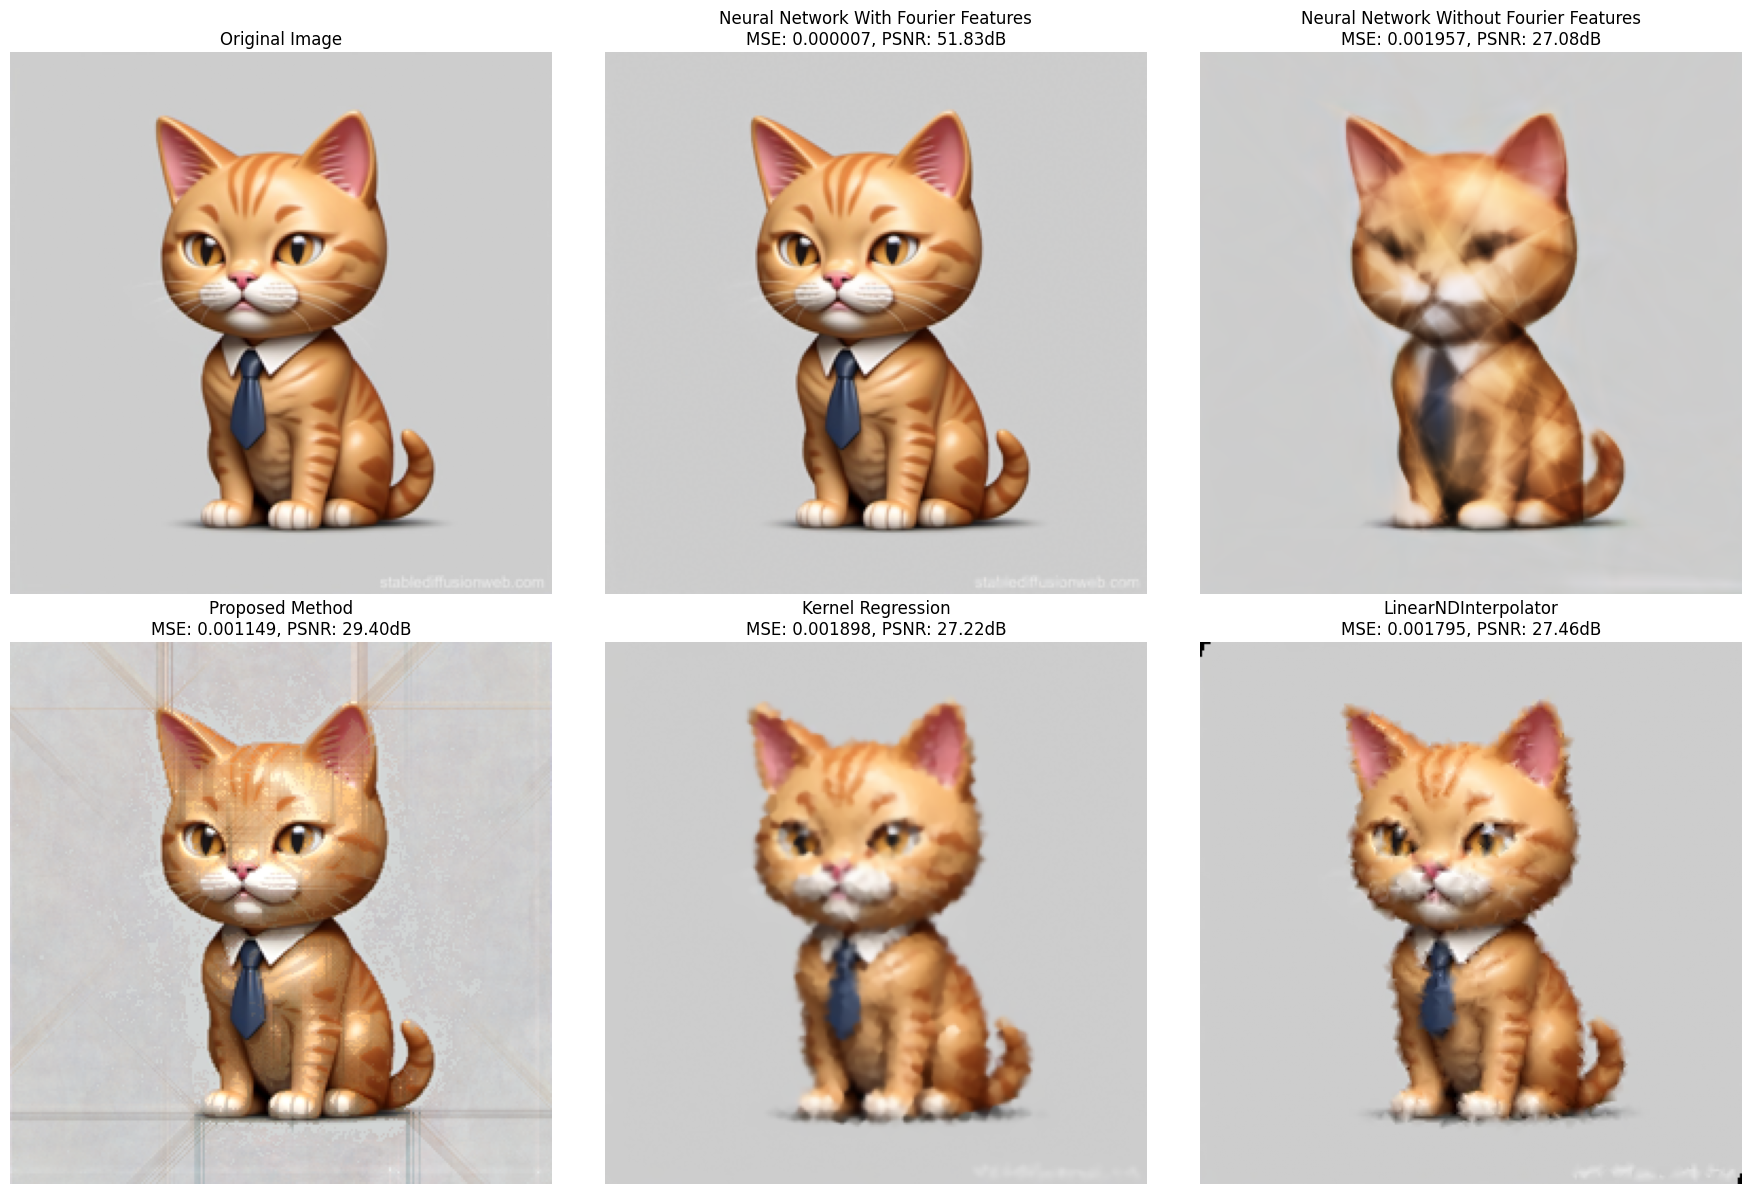

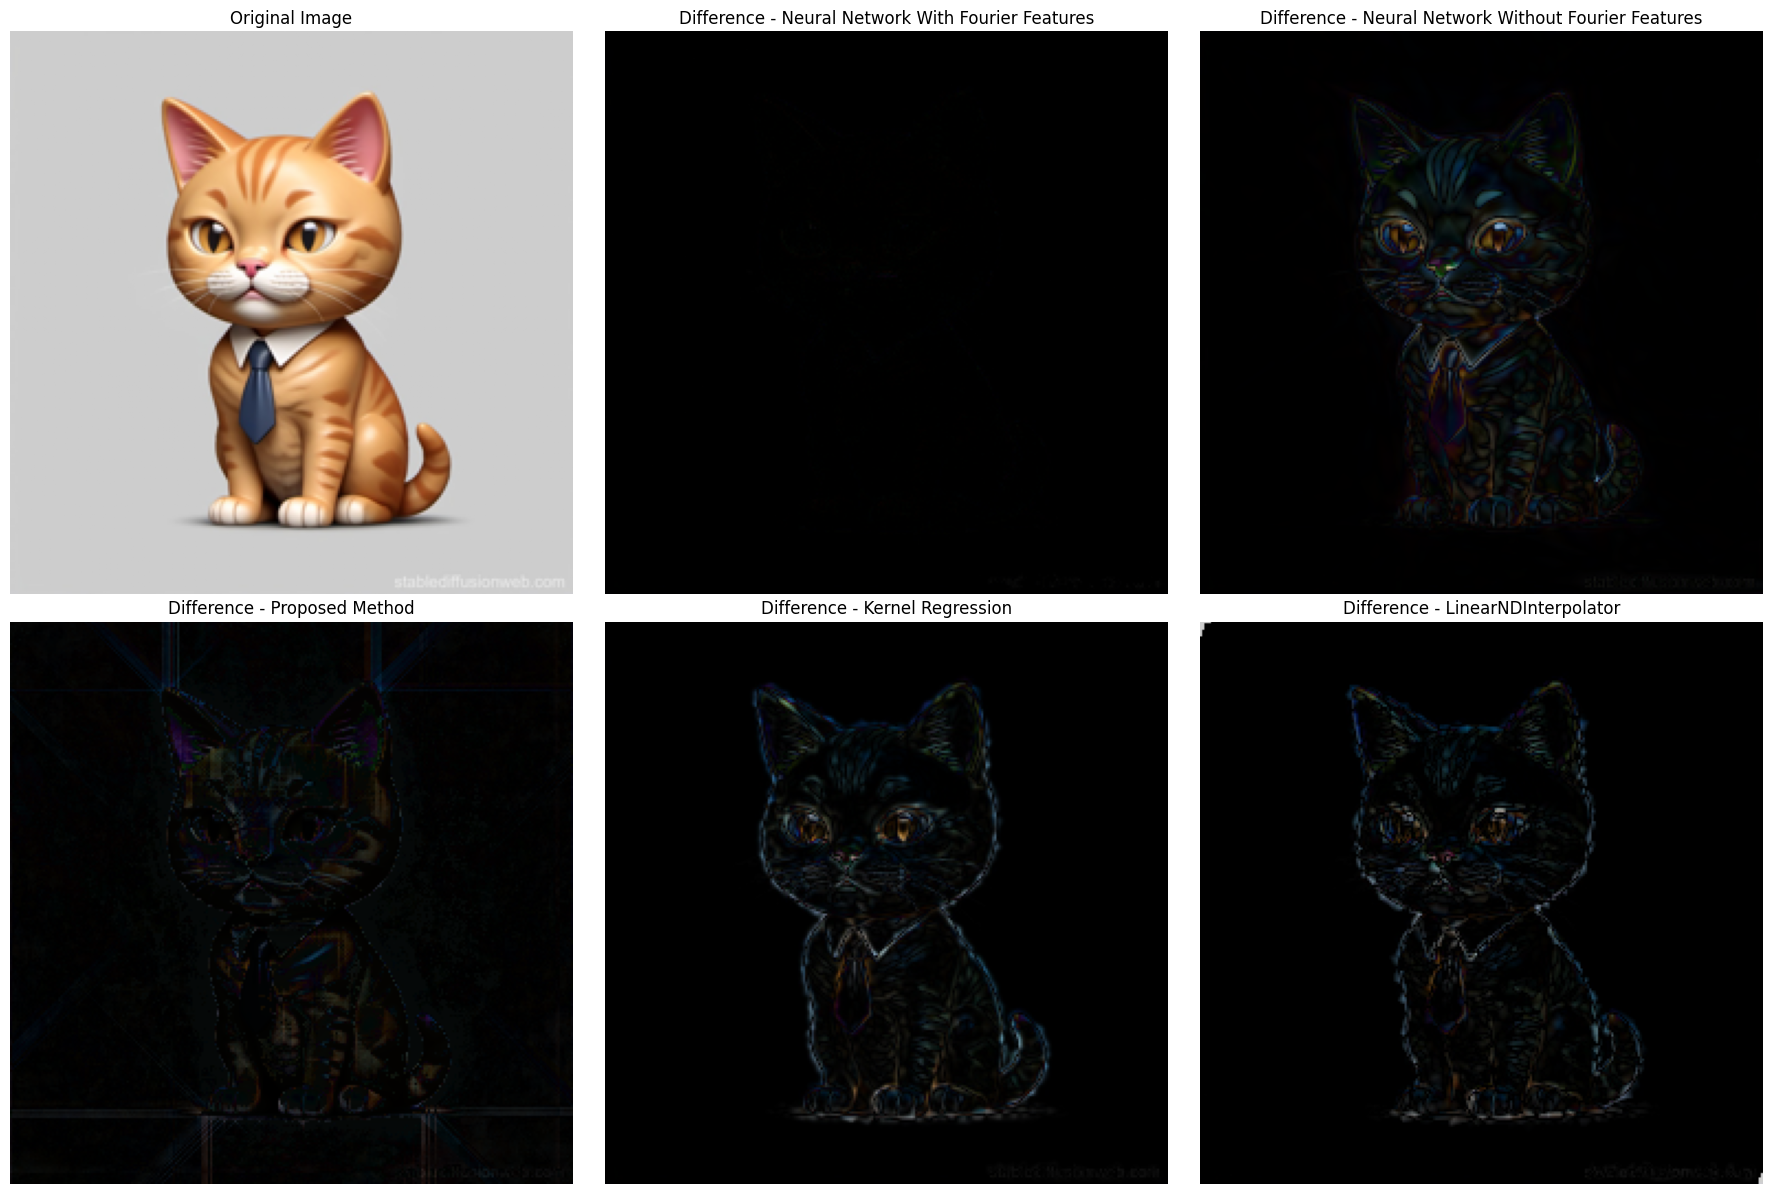

In [257]:

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(reconstructed_fourier)
plt.title(f'Neural Network With Fourier Features\nMSE: {mse_fourier:.6f}, PSNR: {psnr_fourier:.2f}dB')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(reconstructed_no_fourier)
plt.title(f'Neural Network Without Fourier Features\nMSE: {mse_no_fourier:.6f}, PSNR: {psnr_no_fourier:.2f}dB')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(reconstructed_opt)
plt.title(f'Proposed Method\nMSE: {mse_opt:.6f}, PSNR: {psnr_opt:.2f}dB')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(reconstructed_kernel)
plt.title(f'Kernel Regression\nMSE: {mse_kernel:.6f}, PSNR: {psnr_kernel:.2f}dB')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(reconstructed)
plt.title(f'LinearNDInterpolator\nMSE: {mse:.6f}, PSNR: {psnr:.2f}dB')
plt.axis('off')

plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(np.abs(image - reconstructed_fourier))
plt.title('Difference - Neural Network With Fourier Features')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(np.abs(image - reconstructed_no_fourier))
plt.title('Difference - Neural Network Without Fourier Features')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(np.abs(image - reconstructed_opt))
plt.title('Difference - Proposed Method')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.abs(image - reconstructed_kernel))
plt.title('Difference - Kernel Regression')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(np.abs(image -reconstructed))
plt.title('Difference - LinearNDInterpolator')
plt.axis('off')

plt.tight_layout()
plt.show()


In [258]:
print("PSNR and MSE Values for Different Methods:\n")

# Method 1 - With Fourier Features
print(f"Neural Network With Fourier Features:\nMSE: {mse_fourier:.6f}, PSNR: {psnr_fourier:.2f} dB\n")

# Method 1 - Without Fourier Features
print(f"Neural Network Without Fourier Features:\nMSE: {mse_no_fourier:.6f}, PSNR: {psnr_no_fourier:.2f} dB\n")

# Method 2 - Optimized Projection
print(f"Method 2 - Proposed Method:\nMSE: {mse_opt:.6f}, PSNR: {psnr_opt:.2f} dB\n")

# Kernel Regression
print(f"Kernel Regression:\nMSE: {mse_kernel:.6f}, PSNR: {psnr_kernel:.2f} dB\n")

# LinearNDInterpolator
print(f"LinearNDInterpolator:\nMSE: {mse:.6f}, PSNR: {psnr:.2f} dB\n")


PSNR and MSE Values for Different Methods:

Neural Network With Fourier Features:
MSE: 0.000007, PSNR: 51.83 dB

Neural Network Without Fourier Features:
MSE: 0.001957, PSNR: 27.08 dB

Method 2 - Proposed Method:
MSE: 0.001149, PSNR: 29.40 dB

Kernel Regression:
MSE: 0.001898, PSNR: 27.22 dB

LinearNDInterpolator:
MSE: 0.001795, PSNR: 27.46 dB



C:\Users\85816\AppData\Local\Temp\ipykernel_34508\3930163161.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


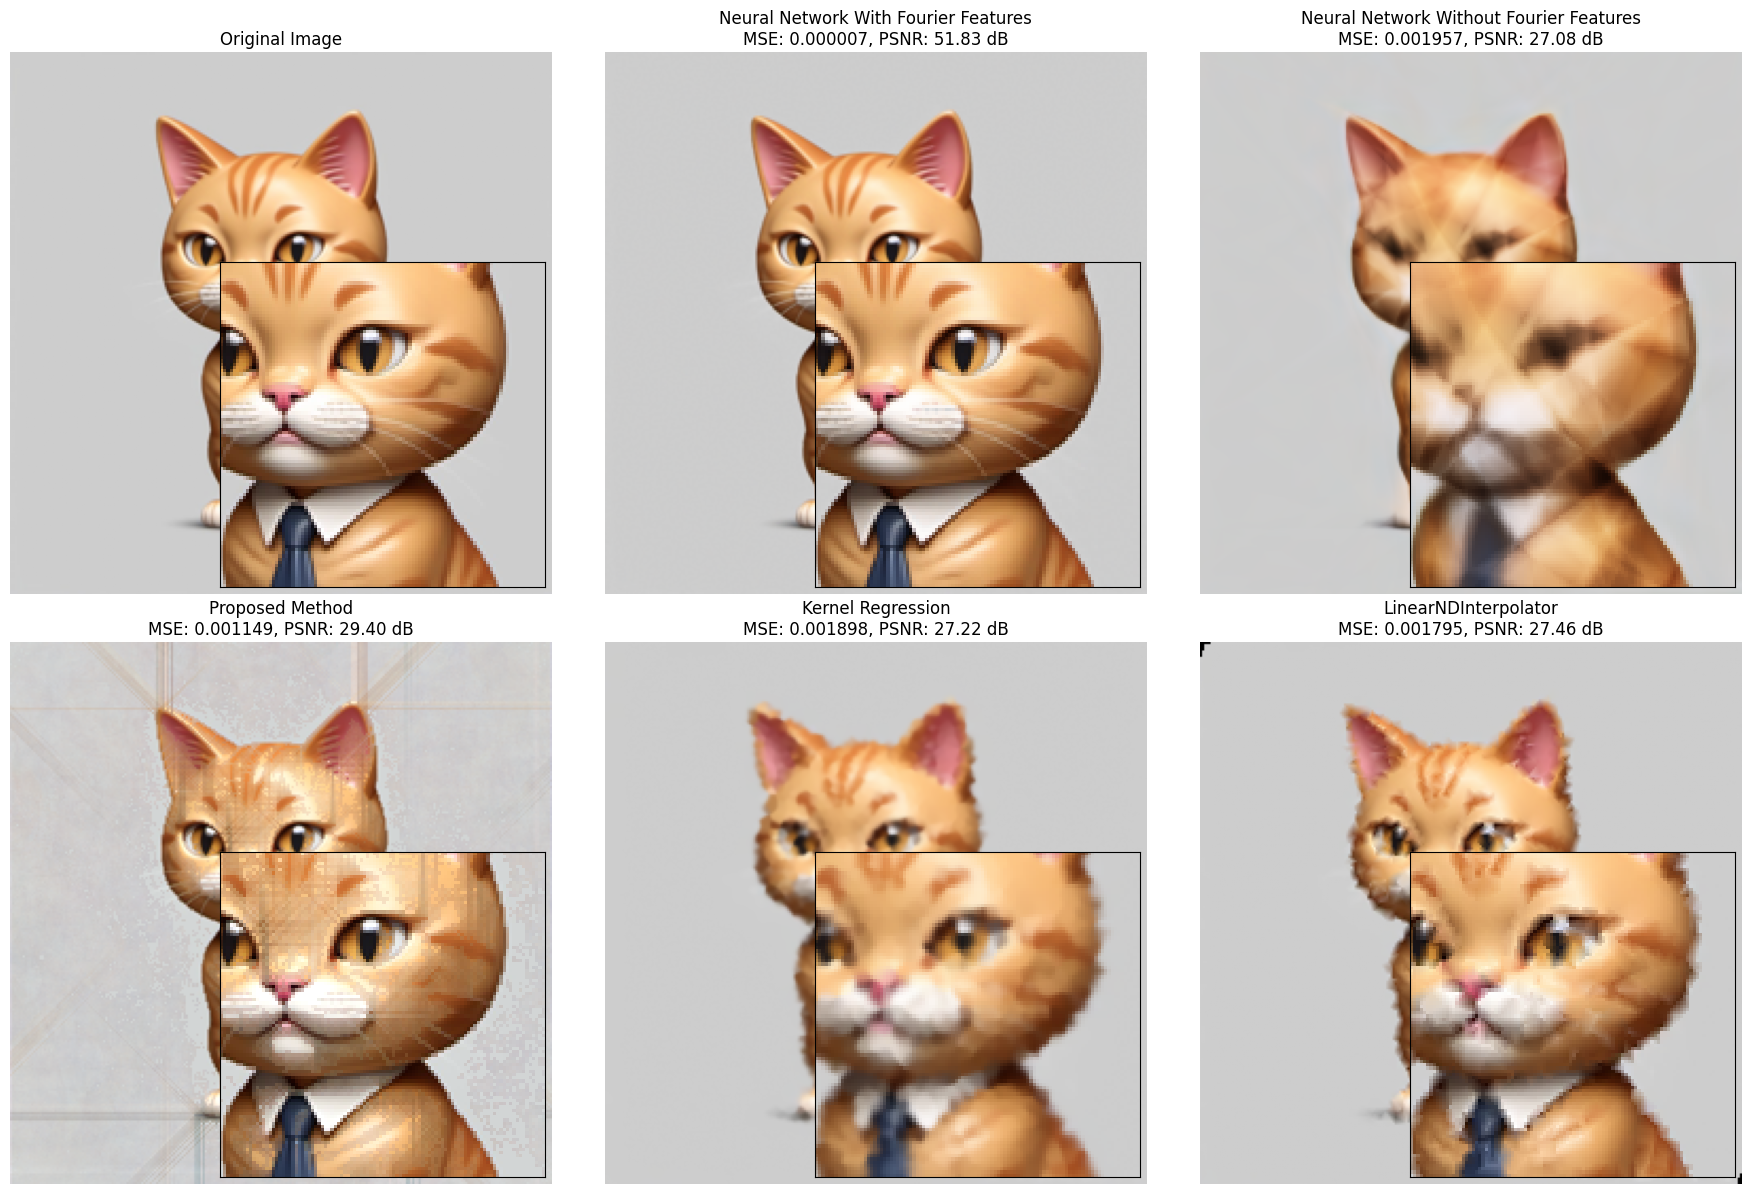

In [259]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# 假设有各种图像的numpy数组
# image, reconstructed_fourier, reconstructed_no_fourier, 等

# 定义放大区域，例如图像中心的100x100像素区域
x1, x2, y1, y2 = 90, 190, 90, 190  # 请根据实际图像大小调整这些值

fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 子图列表
subplots = [
    (image, 'Original Image'),
    (reconstructed_fourier, f'Neural Network With Fourier Features\nMSE: {mse_fourier:.6f}, PSNR: {psnr_fourier:.2f} dB'),
    (reconstructed_no_fourier, f'Neural Network Without Fourier Features\nMSE: {mse_no_fourier:.6f}, PSNR: {psnr_no_fourier:.2f} dB'),
    (reconstructed_opt, f'Proposed Method\nMSE: {mse_opt:.6f}, PSNR: {psnr_opt:.2f} dB'),
    (reconstructed_kernel, f'Kernel Regression\nMSE: {mse_kernel:.6f}, PSNR: {psnr_kernel:.2f} dB'),
    (reconstructed, f'LinearNDInterpolator\nMSE: {mse:.6f}, PSNR: {psnr:.2f} dB')
]

# 遍历每个子图设置
for ax, (img, title) in zip(axs.flat, subplots):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    
    # 在每个子图中创建放大镜
    axins = inset_axes(ax, width="60%", height="60%", loc='lower right')  # 可以调整位置
    axins.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], origin="upper")
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)  # 修改这里以修正方向
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])

plt.tight_layout()
plt.show()
